In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers
from keras import backend as K
from keras import Sequential, Input
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import math
from functools import partial

In [29]:
K.clear_session()

In [30]:
physical_devices = tf.config.list_physical_devices()
CLASSES = 48
IMAGE_SIZE = 24

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [31]:
# tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - negro, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [32]:
def read_file(filename):
  
  with open(filename, 'r') as file:
    file.readline() # we skip the first line as it is not needed
    number_of_pixels = int(file.readline())

    features = []
    labels = []

    for line in file.readlines():
      elements = line.split()

      # add features
      pixels = np.array(elements[:number_of_pixels], dtype=float)
      pixels = np.reshape(pixels, [IMAGE_SIZE, IMAGE_SIZE])
      features.append(pixels)

      # add labels
      labels.append(elements[number_of_pixels+2])

    features = np.array(features)
    labels = np.array(labels, dtype=int)

  return features, labels

In [33]:
# classes 0-15
X_0, y_0 = read_file('./data/x24x24.txt')
# classes 16-31
X_1, y_1 = read_file('./data/y24x24.txt')
# # classes 32-48
X_2, y_2 = read_file('./data/z24x24.txt')

print(len(X_0), len(y_0))
print(len(X_1), len(y_1))
print(len(X_2), len(y_2))
# print(X_0)

2321 2321
2208 2208
2306 2306


In [34]:

# Concatenate train and test images
X = np.concatenate((X_0, X_1, X_2))
y = np.concatenate((y_0, y_1, y_2))
print(len(X), len(y))

N_TRAIN_EXAMPLES=int(len(X) * 0.8)
N_TEST_EXAMPLES=len(X) - N_TRAIN_EXAMPLES


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N_TRAIN_EXAMPLES, test_size=N_TEST_EXAMPLES, random_state=42)

# One-Hot encoding
# Getting dummy variables
y_train_fixed = np.zeros((y_train.shape[0], CLASSES))
# y_valid_fixed = np.zeros((y_valid.shape[0], 10))
y_test_fixed = np.zeros((y_test.shape[0], CLASSES))

for i, value in enumerate(y_train):
  y_train_fixed[i][value] = 1
  
for i, value in enumerate(y_test):
  y_test_fixed[i][value] = 1

6835 6835


In [35]:
print(len(X_train))

5468


## Building a model

Testing LeNet-5 Architecture

In [36]:

# conv_regularizer = regularizers.l2(0.0006)
# dense_regularizer = regularizers.l2(0.01)

# conv_regularizer = regularizers.l2(l=0)
# dense_regularizer = regularizers.l2(l=0)

# IMAGE_SIZE = 24
# len(X_train) = 5468

# DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=5, padding="same", activation="relu",
#                         kernel_initializer="he_normal")

# model = tf.keras.Sequential([
#   DefaultConv2D(filters=6, kernel_size=7, input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]),
#   tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  
#   tf.keras.layers.Dropout(0.15),

#   DefaultConv2D(filters=16),
#   tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  
#   tf.keras.layers.Dropout(0.25),

#   DefaultConv2D(filters=120),
  
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dropout(0.35),
#   tf.keras.layers.Dense(units=84, activation='relu', kernel_initializer="he_normal"),
#   tf.keras.layers.Dense(units=CLASSES, activation='softmax'),
# ])

# model.summary()


conv_regularizer = regularizers.l2(0.0006)
dense_regularizer = regularizers.l2(0.01)

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_regularizer=conv_regularizer)


model = keras.Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    DefaultConv2D(96),
    layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Dropout(0.3),
    DefaultConv2D(256, kernel_size=5),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Dropout(0.4),
    DefaultConv2D(384),
    tf.keras.layers.Dropout(0.5),
    DefaultConv2D(384),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(384, activation='relu',
                        kernel_regularizer=dense_regularizer),
    tf.keras.layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │       590,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │        18,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,436,912 (13.11 MB)

 Trainable params: 3,436,912 (13.11 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:

# optimizer = Adam(learning_rate=0.00025)
optimizer = Adam(learning_rate=0.001)

model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Training Preparation

In [38]:
%%time
batch_size = 200
epochs = 250


# K.set_value(model.optimizer.learning_rate, 0.0005)

history = model.fit(
  X_train, y_train_fixed,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
)

Epoch 1/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 477ms/step - accuracy: 0.0183 - loss: 9.3133 - val_accuracy: 0.0320 - val_loss: 6.2279
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 470ms/step - accuracy: 0.0334 - loss: 5.6663 - val_accuracy: 0.0384 - val_loss: 4.5329
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - accuracy: 0.0267 - loss: 4.3567 - val_accuracy: 0.0457 - val_loss: 3.9789
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - accuracy: 0.0438 - loss: 3.9347 - val_accuracy: 0.0457 - val_loss: 3.8039
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - accuracy: 0.0453 - loss: 3.7746 - val_accuracy: 0.0521 - val_loss: 3.7018
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 0.0587 - loss: 3.6670 - val_accuracy: 0.0494 - val_loss: 3.6370
Epoch 7/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.0576 - loss: 3.6048 - val_accuracy: 0.0786 - val_loss: 3.5265
Epoch 8/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - accuracy: 0.0807 - loss: 3.4708 - 

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, y_test_fixed)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7746 - loss: 0.7592


[0.7333195209503174, 0.7790782451629639]

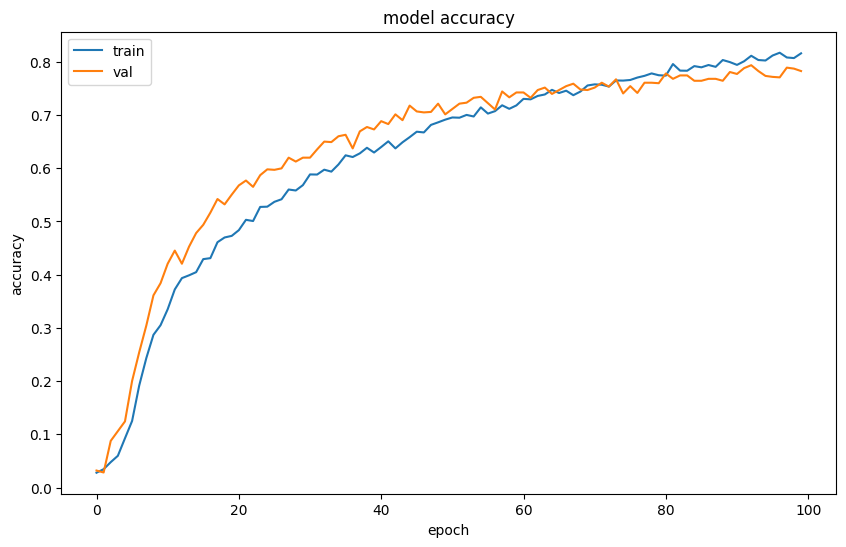

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
length = len(history.history['accuracy'])
print(history.history['accuracy'][length-1])
print(history.history['val_accuracy'][length-1])

0.8157293200492859
0.7824497222900391
